In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datamol as dm
import pandas as pd
import safe as sf

In [3]:
from rdkit.Chem.Scaffolds import MurckoScaffold

def fraction_atom_in_scaff(mol: dm.Mol):

    """Compute the fraction of atoms that belong to any ring system of a molecule
    as defined by its murcko scaffold

    Args:
        mol: input molecule
    """
    n_heavy_atoms = mol.GetNumHeavyAtoms()
    if n_heavy_atoms < 1:
        return 0

    n_heavy_scaffold_atoms = 0
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    scaffold = dm.sanitize_mol(scaffold)

    if scaffold is not None:
        n_heavy_scaffold_atoms = scaffold.GetNumHeavyAtoms()

    return n_heavy_scaffold_atoms / n_heavy_atoms


df = pd.read_csv("https://raw.githubusercontent.com/datamol-io/datamol/e3c4a38cc217f08420f87ad9a87afe44dd9d3667/datamol/data/chembl_drugs.csv")
df = df[~df["smiles"].str.contains("\.")]
df["mol"] = df["smiles"].apply(dm.to_mol)
df["mw"]  = df["mol"].apply(dm.descriptors.mw)
df["clogp"]  = df["mol"].apply(dm.descriptors.clogp)
df["tpsa"]  = df["mol"].apply(dm.descriptors.tpsa)
df["qed"]  = df["mol"].apply(dm.descriptors.qed)

df["ratio_ring"] = df["mol"].apply(fraction_atom_in_scaff)
df["sascore"] = df["mol"].apply(dm.descriptors.sas)
df["n_rings"] = df["mol"].apply(dm.descriptors.n_rings)
df["n_heavy_atoms"] = df["mol"].apply(dm.descriptors.n_heavy_atoms)

In [4]:
df = df.query("n_heavy_atoms > 20 and mw > 350 and mw < 700 and tpsa < 200  and clogp < 5 and qed > 0.4 and ratio_ring > 0.3 and sascore < 6 and sascore > 2 and n_rings > 1 and n_rings < 7")

In [5]:
centroids = dm.pick_diverse(df.mol.values, npick=50)

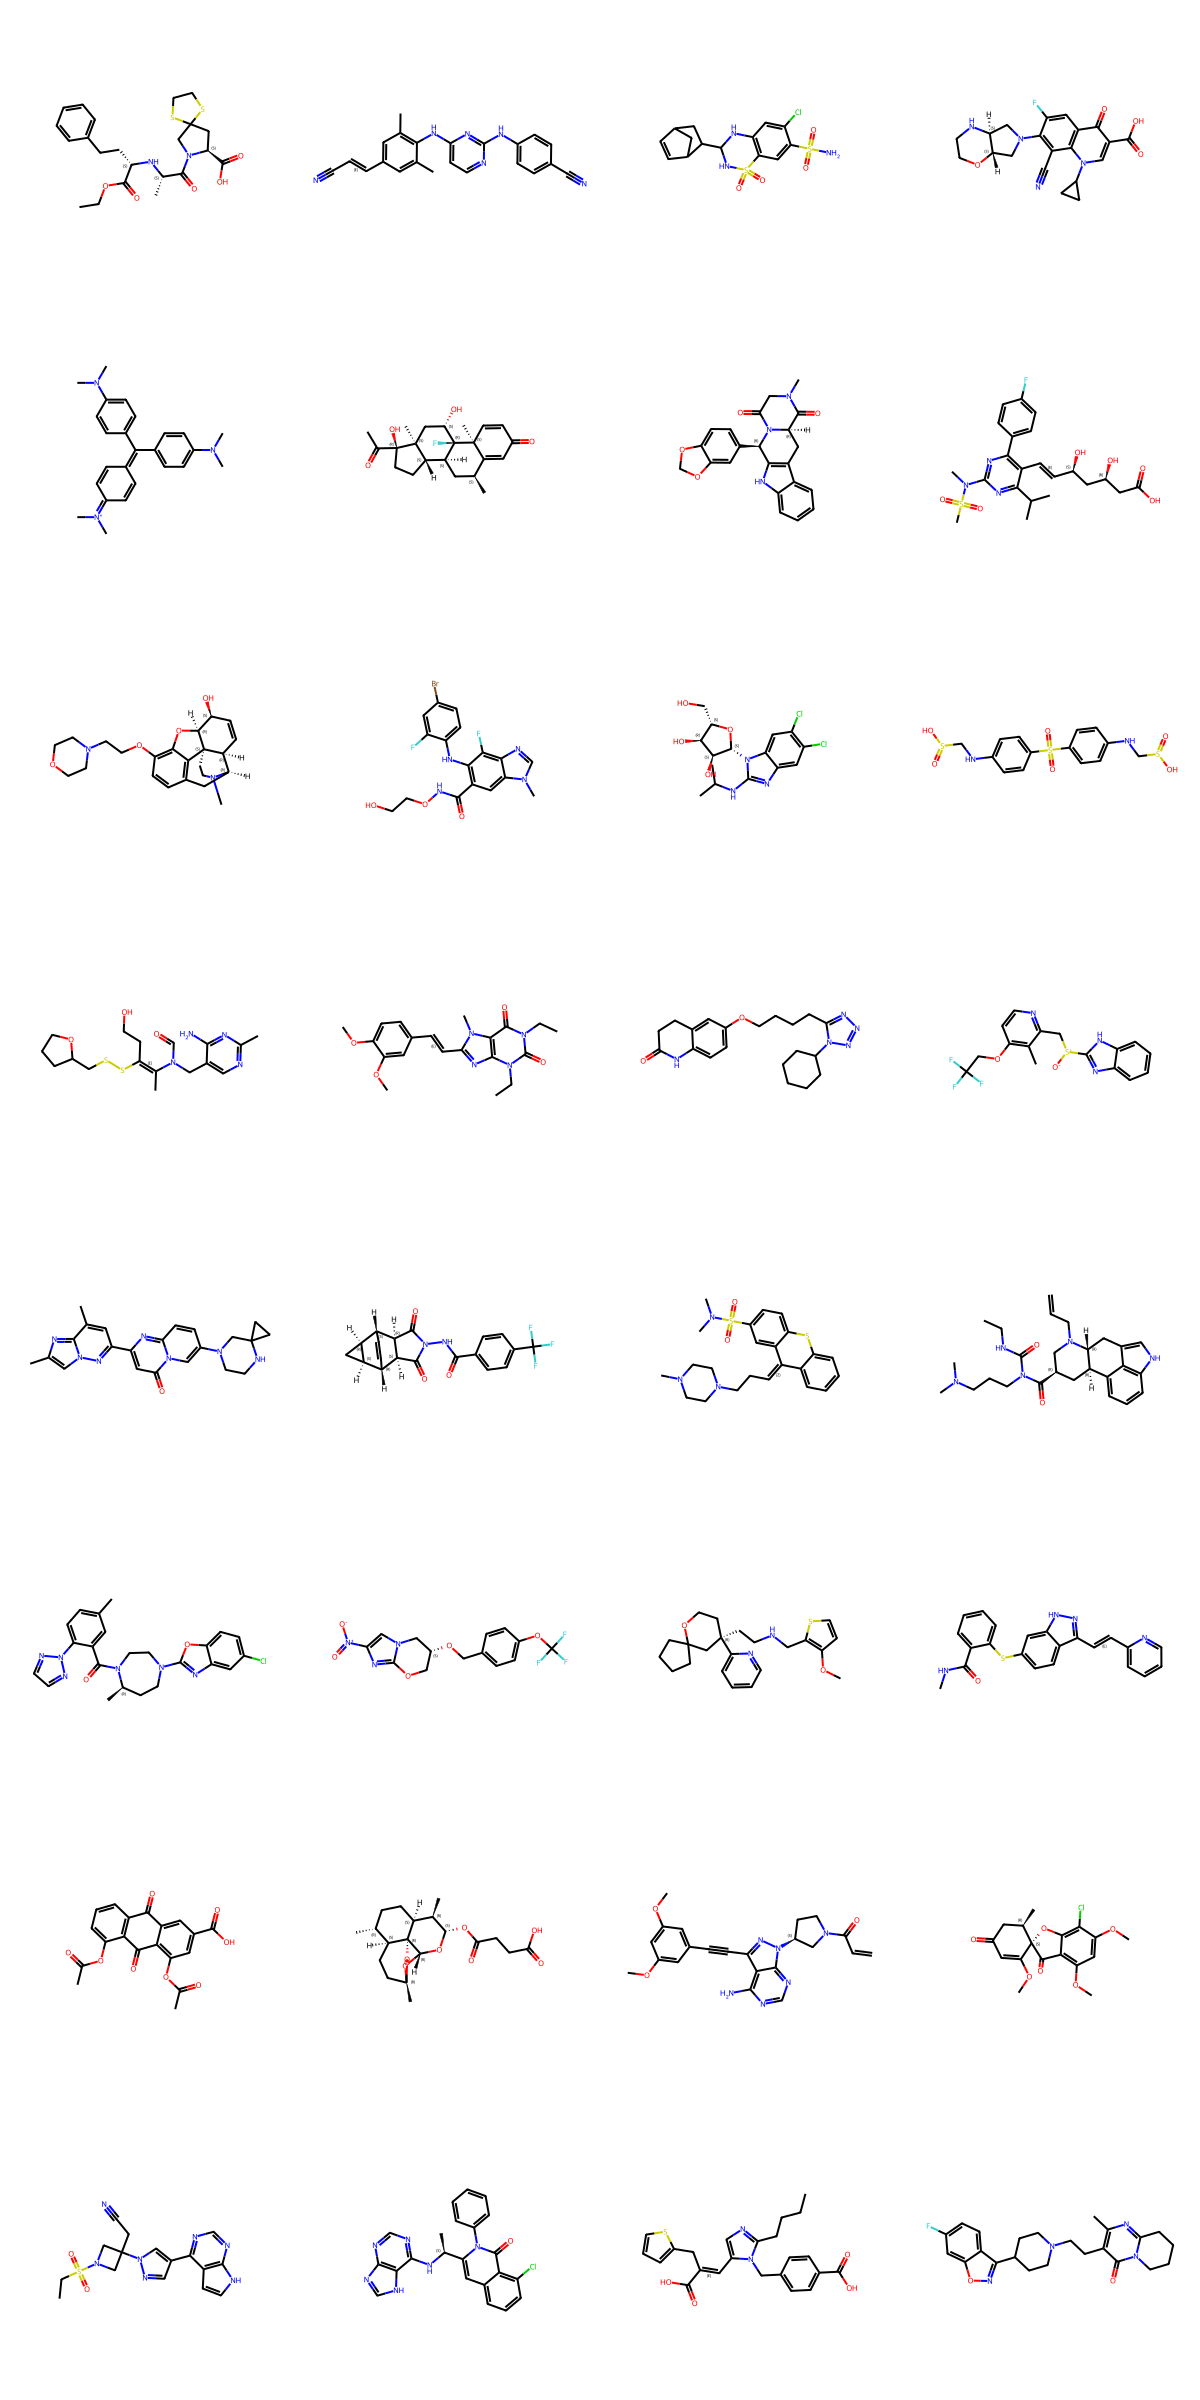

In [6]:
dm.to_image(centroids[-1], use_svg=False)

In [7]:
from chembl_webresource_client.new_client import new_client

molecule = new_client.molecule
def find_mol(x):
    mol = molecule.filter(molecule_structures__standard_inchi_key=dm.to_inchikey(x)).only(['molecule_chembl_id', 'pref_name', "dosed_ingredient", "indication_class", "oral","molecule_type", "therapeutic_flag", "usan_stem_definition", "usan_year", "withdrawn_flag"])
    mol = mol[0]
    mol["smiles"] = dm.to_smiles(x)
    mol["inchikey"] = dm.to_inchikey(x)
    return mol

In [8]:

selected_df = pd.DataFrame.from_dict([find_mol(centroids[-1][i]) for i in range(50)])

In [9]:
selected_df.iloc[12:16]

,dosed_ingredient,indication_class,molecule_chembl_id,molecule_type,oral,pref_name,therapeutic_flag,usan_stem,usan_stem_definition,usan_year,withdrawn_flag,smiles,inchikey
12,True,None,CHEMBL1740659,Small molecule,False,FURSULTIAMINE,False,None,None,NaN,False,C/C(=C(/CCO)SSCC1CCCO1)N(C=O)Cc1cnc(C)nc1N,JTLXCMOFVBXEKD-FOWTUZBSSA-N
13,True,None,CHEMBL431770,Small molecule,True,ISTRADEFYLLINE,True,-fylline,theophylline derivatives,2003.0,False,CCn1c(=O)c2c(nc(/C=C/c3ccc(OC)c(OC)c3)n2C)n(CC...,IQVRBWUUXZMOPW-PKNBQFBNSA-N
14,True,Inhibitor (platelet); Vasodilator; Antithrombotic,CHEMBL799,Small molecule,True,CILOSTAZOL,True,None,None,1997.0,False,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1,RRGUKTPIGVIEKM-UHFFFAOYSA-N
15,True,Anti-Ulcerative,CHEMBL480,Small molecule,True,LANSOPRAZOLE,True,-prazole,antiulcer agents (benzimidazole derivatives),1989.0,False,Cc1c(OCC(F)(F)F)ccnc1C[S+]([O-])c1nc2ccccc2[nH]1,MJIHNNLFOKEZEW-UHFFFAOYSA-N


In [10]:
selected_df = selected_df.dropna(subset=["usan_year"])

In [11]:
selected_df["mol"] = selected_df["smiles"].apply(dm.to_mol)

In [12]:
selected_drugs = set(["ERLOTINIB", "INDOMETHACIN", "LESINURAD", "IXABEPILONE", "TERCONAZOLE", "FILGOTINIB", "CLINDAMYCIN", "CELECOXIB", "LOVASTATIN", "LIOTHYRONINE", "BELZUTIFAN", "ELIGLUSTAT", "CEFAZOLIN", 'FUTIBATINIB', 'BARICITINIB', 'DUVELISIB', 'EPROSARTAN', "AXITINIB", 'SPIRAPRIL', 'RILPIVIRINE', 'CYCLOTHIAZIDE', "ARTESUNATE", 'ROSUVASTATIN',  'MARIBAVIR', 'ISTRADEFYLLINE', 'CILOSTAZOL',  'RISDIPLAM'])
len(selected_drugs)

27

In [13]:
selected_df_final = selected_df[selected_df.pref_name.isin(selected_drugs)]

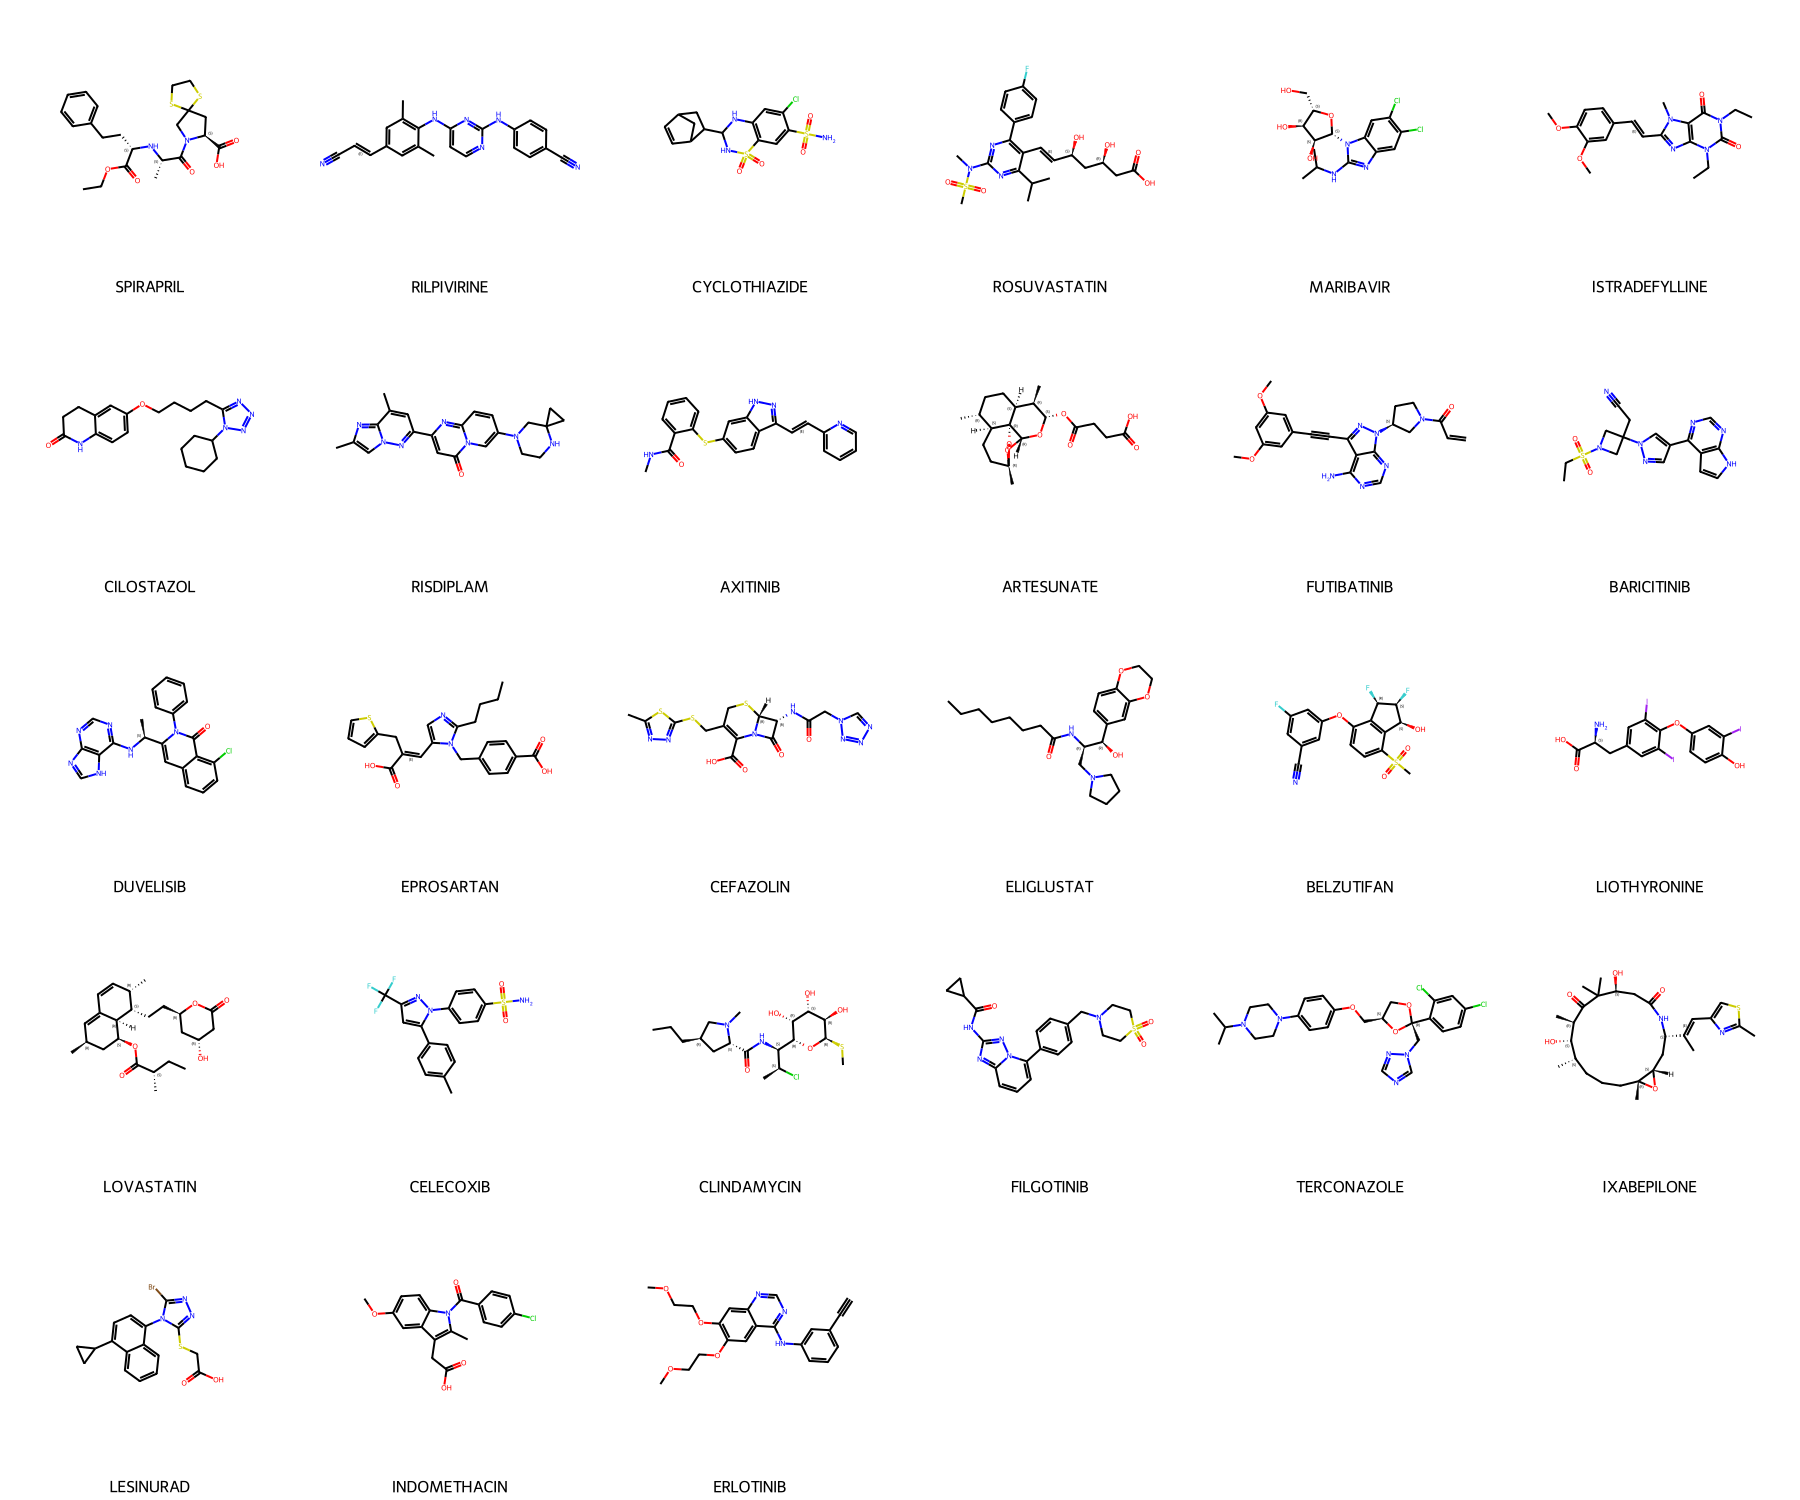

In [14]:
dm.to_image(selected_df_final["mol"].values, legends=selected_df_final["pref_name"].tolist(), use_svg=False, n_cols=6, max_mols=50)

In [52]:
from rdkit import Chem
def slice(x):
    with dm.without_rdkit_log():
        mol_linker_slicer = sf.utils.MolSlicer(shortest_linker=False, require_ring_system=True)
        try:
            out = mol_linker_slicer(x)
        except:    
            mol_linker_slicer = sf.utils.MolSlicer(shortest_linker=False, require_ring_system=False)
            out =  mol_linker_slicer(x)
    return [dm.to_smiles(m) for m in out]

def compute_substructure(x):
    return dm.to_smiles(dm.to_scaffold_murcko(x))

def to_scaffold(x):
    scaffold = dm.to_scaffold_murcko(x)
    return dm.to_smiles(Chem.ReplaceSidechains(x, scaffold))

def to_sidechains(x):
    try:
        return ".".join([x[0], x[-1]])
    except:
        return None

def to_motif(x):
    return x[0]

In [53]:
selected_df_final["slices"] = selected_df_final["mol"].apply(slice)

/tmp/ipykernel_2427999/1021956843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df_final["slices"] = selected_df_final["mol"].apply(slice)


In [54]:
selected_df_final["sidechains"] = selected_df_final["slices"].apply(to_sidechains)
selected_df_final["motif"] = selected_df_final["slices"].apply(to_motif)
selected_df_final["scaffold"] = selected_df_final["mol"].apply(to_scaffold)
selected_df_final["substructure"] = selected_df_final["mol"].apply(compute_substructure)

/tmp/ipykernel_2427999/859985865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df_final["sidechains"] = selected_df_final["slices"].apply(to_sidechains)
/tmp/ipykernel_2427999/859985865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df_final["motif"] = selected_df_final["slices"].apply(to_motif)
/tmp/ipykernel_2427999/859985865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [55]:
selected_df_final = selected_df_final.dropna(subset=["sidechains"])

In [56]:
selected_df_final

,dosed_ingredient,indication_class,molecule_chembl_id,molecule_type,oral,pref_name,therapeutic_flag,usan_stem,usan_stem_definition,usan_year,withdrawn_flag,smiles,inchikey,mol,slices,sidechains,motif,scaffold,substructure
0,False,Enzyme Inhibitor (angiotensin-converting),CHEMBL431,Small molecule,True,SPIRAPRIL,True,-pril,antihypertensives (ACE inhibitors),1987.0,False,CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CC2(...,HRWCVUIFMSZDJS-SZMVWBNQSA-N,<rdkit.Chem.rdchem.Mol object at 0x7f394a878a50>,"[[7*]c1ccccc1, [8*]CC[C@H](N[C@@H](C)C([19*])=...",[7*]c1ccccc1.[17*]N1CC2(C[C@H]1C(=O)O)SCCS2,[7*]c1ccccc1,[1*][C@H](CCc1ccccc1)N[C@@H]([2*])C(=O)N1CC2(C...,O=C(CNCCCc1ccccc1)N1CCC2(C1)SCCS2
1,True,None,CHEMBL175691,Small molecule,True,RILPIVIRINE,True,-vir-,antivirals: non-nucleoside reverse transcripta...,2009.0,False,Cc1cc(/C=C/C#N)cc(C)c1Nc1ccnc(Nc2ccc(C#N)cc2)n1,YIBOMRUWOWDFLG-ONEGZZNKSA-N,<rdkit.Chem.rdchem.Mol object at 0x7f394a87bca0>,"[[12*]c1c(C)cc(/C=C/C#N)cc1C, [11*]Nc1ccnc(N[1...",[12*]c1c(C)cc(/C=C/C#N)cc1C.[18*]c1ccc(C#N)cc1,[12*]c1c(C)cc(/C=C/C#N)cc1C,[1*]c1cc([2*])cc([3*])c1Nc1ccnc(Nc2ccc([4*])cc...,c1ccc(Nc2ccnc(Nc3ccccc3)n2)cc1
2,True,Antihypertensive; Diuretic,CHEMBL61593,Small molecule,True,CYCLOTHIAZIDE,True,-thiazide,diuretics (thiazide derivatives),1963.0,False,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,BOCUKUHCLICSIY-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7f394a879c40>,"[[13*]C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1, ...",[13*]C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1.[1...,[13*]C1Nc2cc(Cl)c(S(N)(=O)=O)cc2S(=O)(=O)N1,[1*]c1cc2c(cc1[2*])NC(C1CC3C=CC1C3)NS2(=O)=O,O=S1(=O)NC(C2CC3C=CC2C3)Nc2ccccc21
7,False,None,CHEMBL1496,Small molecule,True,ROSUVASTATIN,True,-stat-,enzyme inhibitors: antihyperlipidemics (HMG-Co...,2000.0,False,CC(C)c1nc(N(C)S(C)(=O)=O)nc(-c2ccc(F)cc2)c1/C=...,BPRHUIZQVSMCRT-VEUZHWNKSA-N,<rdkit.Chem.rdchem.Mol object at 0x7f394a879d90>,[[14*]c1nc(N(C)S(C)(=O)=O)nc(C(C)C)c1/C=C/[C@@...,[14*]c1nc(N(C)S(C)(=O)=O)nc(C(C)C)c1/C=C/[C@@H...,[14*]c1nc(N(C)S(C)(=O)=O)nc(C(C)C)c1/C=C/[C@@H...,[1*]c1nc([2*])nc(-c2ccc([3*])cc2)c1[4*],c1ccc(-c2ccncn2)cc1
10,True,None,CHEMBL515408,Small molecule,True,MARIBAVIR,True,-vir,antivirals,1998.0,False,CC(C)Nc1nc2cc(Cl)c(Cl)cc2n1[C@H]1O[C@@H](CO)[C...,KJFBVJALEQWJBS-XUXIUFHCSA-N,<rdkit.Chem.rdchem.Mol object at 0x7f394a878890>,"[[15*]n1c(NC(C)C)nc2cc(Cl)c(Cl)cc21, None, [14...",[15*]n1c(NC(C)C)nc2cc(Cl)c(Cl)cc21.[14*][C@H]1...,[15*]n1c(NC(C)C)nc2cc(Cl)c(Cl)cc21,[1*]c1nc2cc([2*])c([3*])cc2n1[C@H]1O[C@@H]([4*...,c1ccc2c(c1)ncn2[C@@H]1CCCO1
13,True,None,CHEMBL431770,Small molecule,True,ISTRADEFYLLINE,True,-fylline,theophylline derivatives,2003.0,False,CCn1c(=O)c2c(nc(/C=C/c3ccc(OC)c(OC)c3)n2C)n(CC...,IQVRBWUUXZMOPW-PKNBQFBNSA-N,<rdkit.Chem.rdchem.Mol object at 0x7f394a879cb0>,"[[9*]c1nc2c(c(=O)n(CC)c(=O)n2CC)n1C, [8*]/C=C/...",[9*]c1nc2c(c(=O)n(CC)c(=O)n2CC)n1C.[10*]c1ccc(...,[9*]c1nc2c(c(=O)n(CC)c(=O)n2CC)n1C,[1*]n1c(=O)c2c(nc(/C=C/c3ccc([2*])c([3*])c3)n2...,O=c1[nH]c(=O)c2[nH]c(/C=C/c3ccccc3)nc2[nH]1
14,True,Inhibitor (platelet); Vasodilator; Antithrombotic,CHEMBL799,Small molecule,True,CILOSTAZOL,True,None,None,1997.0,False,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1,RRGUKTPIGVIEKM-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7f394a86e9d0>,"[[7*]c1ccc2c(c1)CCC(=O)N2, [6*]OCCCCc1nnnn1[17...",[7*]c1ccc2c(c1)CCC(=O)N2.[16*]C1CCCCC1,[7*]c1ccc2c(c1)CCC(=O)N2,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1
16,True,None,CHEMBL4297528,Small molecule,True,RISDIPLAM,True,-plam,survival motor neurin SMN1 and SMN2 splicing m...,2018.0,False,Cc1cn2nc(-c3cc(=O)n4cc(N5CCNC6(CC6)C5)ccc4n3)c...,ASKZRYGFUPSJPN-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7f394a86dee0>,"[[6*]c1cc(C)c2nc(C)cn2n1, [5*]c1cc(=O)n2cc([13...",[6*]c1cc(C)c2nc(C)cn2n1.[12*]N1CCNC2(CC2)C1,[6*]c1cc(C)c2nc(C)cn2n1,[1*]c1cn2nc(-c3cc(=O)n4cc(N5CCNC6(CC6)C5)ccc4n...,O=c1cc(-c2ccc3nccn3n2)nc2ccc(N3CCNC4(CC4)C3)cn12
23,True,None,CHEMBL1289926,Small molecule,True,AXITINIB,True,-tini

In [2]:
selected_df["slices"] = selected_df["mol"].apply(mol_linker_slicer)

selected_df["sidechains"] = selected_df["slices"].apply((x[0], x[-1]))
#mol = dm.to_image(mol_linker_slicer(selected_df_final["mol"].values[0]))
#selected_df["slices"] = selected_df["mol"].apply(mol_linker_slicer)

NameError: name 'selected_df' is not defined

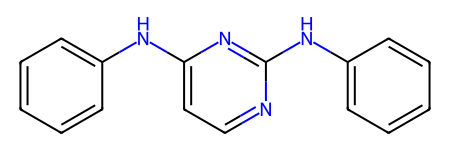

In [40]:
sc = compute_substructure(selected_df_final["mol"].values[1])
sc

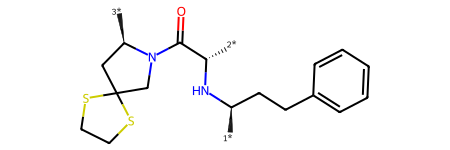

In [38]:
from rdkit import Chem
import safe as sf
Chem.ReplaceSidechains(selected_df_final["mol"].values[0], sc)

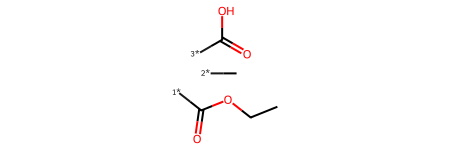

In [36]:
sf.utils.compute_side_chains(selected_df_final["mol"].values[0], sc)